# Investigate a stock to understand what the target "looks like"

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
#from pprint import pprint
import numpy as np

import random
#import memory_profiler
#import altair as alt
#from tqdm import tqdm
import datetime

#import ipython_memory_usage
#%ipython_memory_usage_start


In [49]:
from utility import ROOT, TEST_CSV, TRAIN_CSV
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])

#stock_id = 10
stock_id = 1
df_train_stock_id = df_train_all.query('stock_id==@stock_id')

In [50]:
def load_parquet(ROOT, filename, stock_id):
    df_book_train_stock_X = pd.read_parquet(os.path.join(ROOT, f"{filename}/stock_id={stock_id}"))
    df_book_train_stock_X["stock_id"] = stock_id
    df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
    return df_book_train_stock_X

df_book_orig = load_parquet(ROOT, 'book_train.parquet', stock_id)
df_trade_orig = load_parquet(ROOT, 'trade_train.parquet', stock_id)

In [51]:
df_train_all.shape

(428932, 1)

In [52]:
df_train_all.sample(100)

,,target
stock_id,time_id,
76,2392,0.004709
31,14886,0.001240
19,6909,0.001229
39,10994,0.002601
125,26693,0.002516
...,...,...
98,229,0.001868
7,12718,0.005584
80,27932,0.005752


In [53]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'   
    is_mixed_numeric = f'numeric mixed {df._data.is_numeric_mixed_type}'
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}, {is_mixed_numeric}')

    

def set_common_mpl_styles(
    ax, legend=True, grid_axis="y", ylabel=None, xlabel=None, title=None, xmin=None, ymin=None, xmax=None, ymax=None,
):
    ax.grid(axis=grid_axis)
    if legend == False:
        ax.legend_.remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if title is not None:
        ax.set_title(title)
    if xmin is not None:
        ax.set_xlim(xmin=xmin)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if xmax is not None:
        ax.set_xlim(xmax=xmax)
    if ymax is not None:
        ax.set_ylim(ymax=ymax)

    
show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True, numeric mixed True


## Identify best/worst plots

In [54]:
df_train = pd.read_csv(os.path.join(ROOT, 'train.csv'))
df_train.sort_values('target', ascending=False)

,stock_id,time_id,target
263356,77,24600,0.070321
202001,59,23823,0.069165
65474,18,2956,0.059256
117293,33,19725,0.051955
56013,15,19725,0.049287
...,...,...,...
107743,31,4142,0.000137
110479,31,27174,0.000123
107832,31,4867,0.000113
107548,31,2479,0.000109


## Trade data

In [55]:
display(df_trade_orig.shape)
df_trade_orig.head()

(296210, 4)

seconds_in_bucket     price  size  order_count
stock_id time_id                                                
1        5                       28  1.002080   553           11
         5                       39  1.002460     8            3
         5                       42  1.002308   147            4
         5                       44  1.002788     1            1
         5                       51  1.002657   100            2

# Calculate a metric on a `time_id` for this `stock_id`

In [56]:
df_book_orig.head()

seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
stock_id time_id                                                          
1        5                        0    1.000754    1.001542    1.000689   
         5                        1    1.000754    1.001673    1.000689   
         5                        2    1.000754    1.001411    1.000623   
         5                        3    1.000754    1.001542    1.000689   
         5                        4    1.000754    1.001476    1.000623   

                  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
stock_id time_id                                                          
1        5          1.001607          1         25         25        100  
         5          1.001739         26         60         25        100  
         5          1.001476          1         25         25        125  
         5          1.001607        125         25        126         36  
         5          1.001542        100        100         25         25

In [136]:
def make_features_stats(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    #print(type(features_var1))
    if isinstance(features_var1, pd.Series):
        # .size yields a series not a df
        #features_var1.name = str(agg_type)
        features_var1 = pd.DataFrame(features_var1, columns=[agg_type])
        #pass
    else:
        features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
        features_var1.columns = features_var1_col_names
    return features_var1


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def _realized_volatility_weighted_sub(ser, weights):
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

def realized_volatility_weighted(ser, weights_type):
    """Weighted volatility"""
    # as a numpy array
    # we drop from 12us to 3us by adding @njit to the _sub function
    # we can't make _sub a closure, it loses all compilation benefits
    # and we can't add njit(cache=True) in Jupyter as it can't
    # find a cache location    
    # as a Series we have 5us and 15us w/wo @njit respectively
    if isinstance(ser, pd.Series):
        ser = ser.to_numpy()
    nbr_items = ser.shape[0]
    if weights_type == 'uniform':
        weights = np.ones(nbr_items)
    elif weights_type == 'linear':
        weights = np.linspace(0.1, 1, nbr_items) # linear increasing weight
    elif weights_type == 'half0half1':
        half_way = int(ser.shape[0] / 2)
        weights = np.concatenate((np.zeros(half_way), np.ones(ser.shape[0] - half_way))) # 0s then 1s weight
    elif weights_type == 'geom':
        weights = np.geomspace(0.01, 1, nbr_items) # geometric increase
    elif weights_type == 'linear2':
        weights = np.linspace(0.5, 1, nbr_items)
    elif weights_type == 'linear3':
        weights = np.linspace(0.75, 1, nbr_items)
    #assert isinstance(weights_type, str) == False, f"Must not be a string like '{weights}' at this point"
    return _realized_volatility_weighted_sub(ser, weights)

def make_wap(df_book_data, num=1, wap_colname="wap", wap_type=1):
    """Modifies df_book_data"""
    if wap_type == 1:
        assert num==1 or num==2
        wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                         df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
        wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
        df_book_data[wap_colname] = wap_numerator / wap_denominator
    else:
        wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'bid_size{num}'] +
                                         df_book_data[f'ask_price{num}'] * df_book_data[f'ask_size{num}'])
        wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
        df_book_data[wap_colname] = wap_numerator / wap_denominator
        

def make_realized_volatility(df_book_data, col, weights="uniform", apply_log_return=True):
    """Consume wap column"""
    new_name = "realized_vol_log_return_" + col + "_" + weights
    if apply_log_return:
        df_book_data[new_name] = df_book_data.groupby(['stock_id', 'time_id'])[col].apply(log_return)
        df_book_data = df_book_data[~df_book_data[new_name].isnull()]
    else:
        df_book_data[new_name] = df_book_data[col]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[new_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

if False: # lightweight tests
    #df_book_train_stock_X = load_book(ROOT, 'book_train.parquet', 0)
    make_wap(df_book_train_stock_X, 2, wap_colname="wap2") # adds 'wap' column
    df_realized_vol_per_stockX = make_realized_volatility(df_book_train_stock_X, col="wap2", weights='linear')
    display(df_realized_vol_per_stockX.head(2))

if False:
    series_log_return = pd.Series(np.linspace(0, 1, 600))
    print(realized_volatility_weighted(series_log_return, weights_type="uniform"))

    #%timeit realized_volatility_weighted(series_log_return, weights_type="uniform")

In [72]:
if False:
    # calculate a standard statistic e.g. mean, var on a single column
    col = ['bid_price1']
    method = 'var'
    df_features = df_book_train_stock_X.groupby('time_id')[col].agg(method)

In [111]:
from sklearn.feature_selection import mutual_info_regression
def plot_mi(df_features, df_train_stock_id):
    df_result = df_features.reset_index().merge(df_train_stock_id, left_on='time_id', right_on='time_id')
    
    n_cols = df_features.columns.shape[0]
    width = 6 * n_cols
    fig, axs = plt.subplots(ncols=n_cols, figsize=(width, 6), constrained_layout=True)
    if n_cols == 1:
        axs = [axs]

    for n_col, col in enumerate(df_features.columns):
        assert df_result[col].isnull().sum() == 0, "Expecting no NaNs"
        #df_result
        ax = axs[n_col]

        mi = mutual_info_regression(df_result[[col]], df_result['target'])[0]

        df_result.plot(kind='scatter', x=col, y='target', ax=ax)
        title = f"{col} with mi {mi:0.2f}"
        set_common_mpl_styles(ax, title=title, ymin=0, )# xmin=0, xmax=1, ymax=1)

## Make realized volatility

,realized_vol_log_return_wap_linear2
time_id,
5,0.004662
11,0.001852


CPU times: user 4.4 s, sys: 87.8 ms, total: 4.49 s
Wall time: 5.54 s


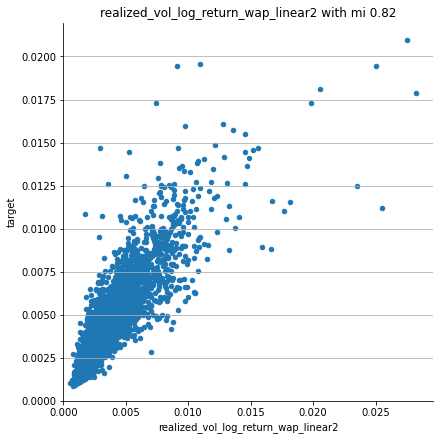

In [77]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
#df_realized_vol = make_realized_volatility(df_book, col="wap", weights='uniform')
df_realized_vol = make_realized_volatility(df_book, col="wap", weights='linear2')
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_wap_linear
time_id,
5,0.003614
11,0.001557


CPU times: user 4.87 s, sys: 67.8 ms, total: 4.94 s
Wall time: 5.87 s


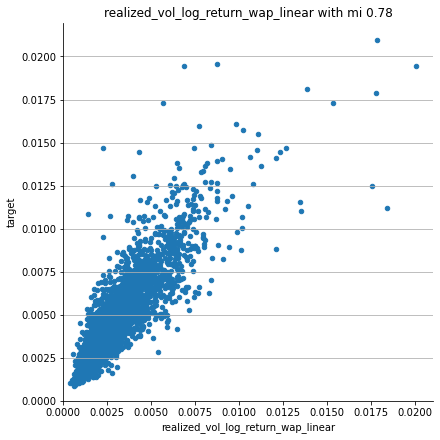

In [76]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
df_realized_vol = make_realized_volatility(df_book, col="wap", weights='linear')
#df_realized_vol = make_realized_volatility(df_book, col="wap", weights='x')
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

### Show WAP vs bid/ask price

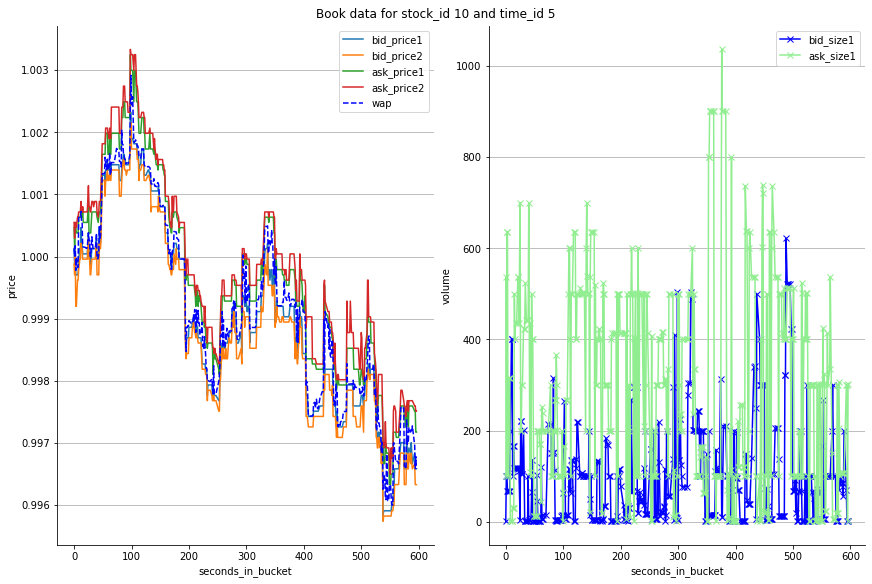

In [38]:
time_id = 5
df_sub = df_book.query('time_id == @time_id').set_index('seconds_in_bucket') # reset_index('stock_id', drop=True)

fig, axs = plt.subplots(ncols=2, figsize=(12,8), constrained_layout=True)
ax = axs[0]
df_sub[['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2']].plot(ax=ax)
df_sub[['wap']].plot(ax=ax, linestyle='--', color='blue')
set_common_mpl_styles(ax, ylabel='price')
ax=axs[1]
# TODO figure out colors!
# only show bid/ask 1 as they're quite spikey and the plot gets confused
df_sub[['bid_size1', 'ask_size1']].plot(ax=ax, marker='x', linestyle='-', color=['blue', 'lightgreen'])
set_common_mpl_styles(ax, ylabel='volume')
fig.suptitle(f'Book data for stock_id {stock_id} and time_id {time_id}');

!!! this needs to not be an empty series!

In [152]:
1/0 this should fix my problem
df_book.reindex(df_book_orig.index, fill_value=0)

seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
stock_id time_id                                                          
1        5                        0         0.0         0.0         0.0   
         5                        0         0.0         0.0         0.0   
         5                        0         0.0         0.0         0.0   
         5                        0         0.0         0.0         0.0   
         5                        0         0.0         0.0         0.0   
...                             ...         ...         ...         ...   
         32767                    0         0.0         0.0         0.0   
         32767                    0         0.0         0.0         0.0   
         32767                    0         0.0         0.0         0.0   
         32767                    0         0.0         0.0         0.0   
         32767                    0         0.0         0.0         0.0   

                  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  wap  \
stock_id time_id                                                                
1        5               0.0          0          0          0          0    0   
         5               0.0          0          0          0          0    0   
         5               0.0          0          0          0          0    0   
         5               0.0          0          0          0          0    0   
         5               0.0          0          0          0          0    0   
...                      ...        ...        ...        ...        ...  ...   
         32767           0.0          0          0          0          0    0   
         32767           0.0          0          0          0          0    0   
         32767           0.0          0          0          0          0    0   
         32767           0.0          0          0          0          0    0   
         32767           0.0          0          0          0          0    0   

                  realized_vol_log_return_wap_uniform  
stock_id time_id                                       
1        5                                        0.0  
         5                                        0.0  
         5                                        0.0  
         5                                        0.0  
         5                                        0.0  
...                                               ...  
         32767                                    0.0  
         32767                                    0.0  
         32767                                    0.0  
         32767                                    0.0  
         32767                                    0.0  

[1507532 rows x 11 columns]

In [147]:
df_book.append(pd.Series({'wap': [0]}), ignore_index=True)
df_book

,,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,realized_vol_log_return_wap_uniform
stock_id,time_id,,,,,,,,,,,


,realized_vol_log_return_wap_uniform_gt599secs
time_id,


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

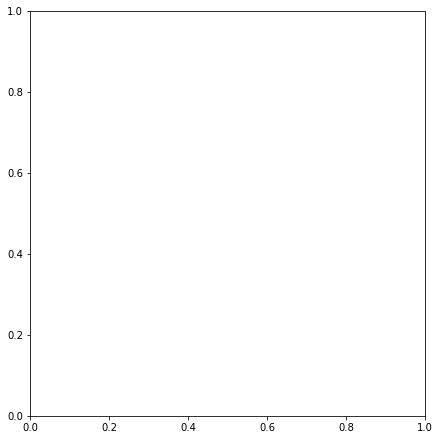

In [142]:
%%time 

df_book = df_book_orig.copy()
#secs_in_bucket = 300
secs_in_bucket = 599
df_book = df_book.query(f'seconds_in_bucket > {secs_in_bucket}')
make_wap(df_book, 1) # adds 'wap' column
if df_book.shape[0] < 1:
    df_book
df_realized_vol = make_realized_volatility(df_book, col="wap", weights="uniform")
df_realized_vol.columns = [df_realized_vol.columns[0] + f"_gt{secs_in_bucket}secs"]
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_wap_uniform
time_id,
5,0.006610
11,0.003482


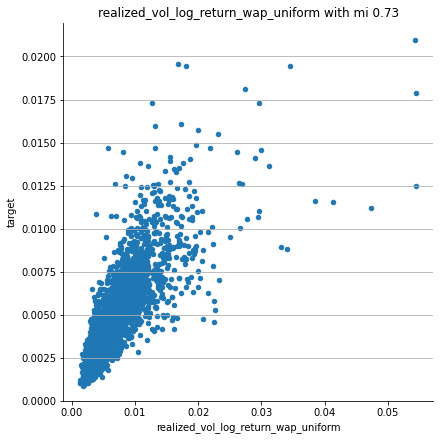

In [140]:
# make_wap(df_book_data, num=1, wap_colname="wap", wap_type=1):

df_book = df_book_orig.copy()
make_wap(df_book, 2, wap_type=2) # adds 'wap' column
df_realized_vol = make_realized_volatility(df_book, col="wap", weights="uniform")
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_ask_price1_uniform
time_id,
5,0.004116
11,0.002118


CPU times: user 4.57 s, sys: 89.7 ms, total: 4.66 s
Wall time: 5.69 s


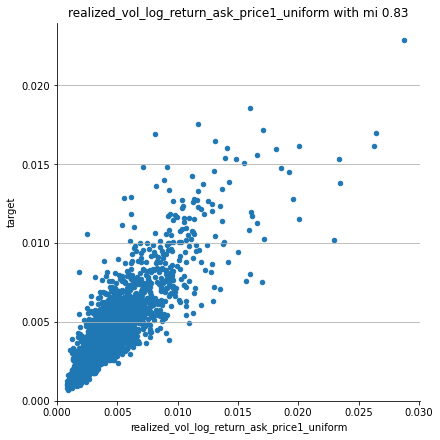

In [19]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
weights = 'uniform'
df_realized_vol = make_realized_volatility(df_book, col="ask_price1", weights=weights)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_ask_price1_half0half1
time_id,
5,0.002930
11,0.001471


CPU times: user 5.4 s, sys: 184 ms, total: 5.58 s
Wall time: 6.79 s


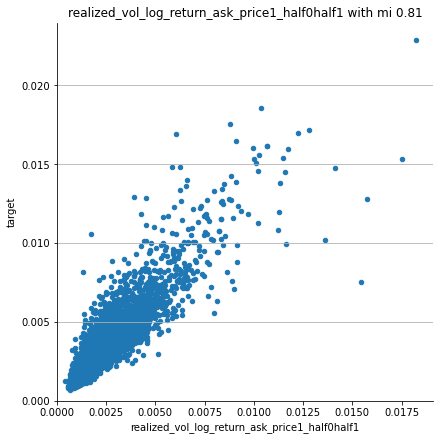

In [20]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
weights = 'half0half1'
df_realized_vol = make_realized_volatility(df_book, col="ask_price1", weights=weights)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_bid_price1_uniform
time_id,
5,0.003859
11,0.001810


CPU times: user 4.67 s, sys: 165 ms, total: 4.83 s
Wall time: 5.84 s


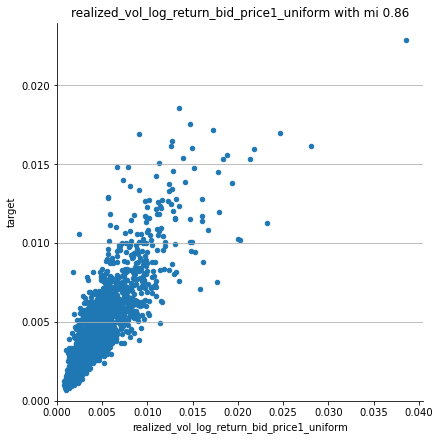

In [21]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
weights = 'uniform'
df_realized_vol = make_realized_volatility(df_book, col="bid_price1", weights=weights)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_ask_size1_uniform
time_id,
5,37.289143
11,20.890409


CPU times: user 4.65 s, sys: 94.5 ms, total: 4.74 s
Wall time: 6.04 s


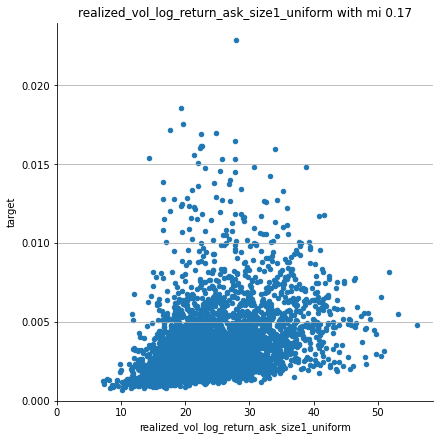

In [22]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
weights = 'uniform'
df_realized_vol = make_realized_volatility(df_book, col="ask_size1", weights=weights)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_bid_size1_uniform
time_id,
5,36.436390
11,26.949002


CPU times: user 4.77 s, sys: 160 ms, total: 4.93 s
Wall time: 6.06 s


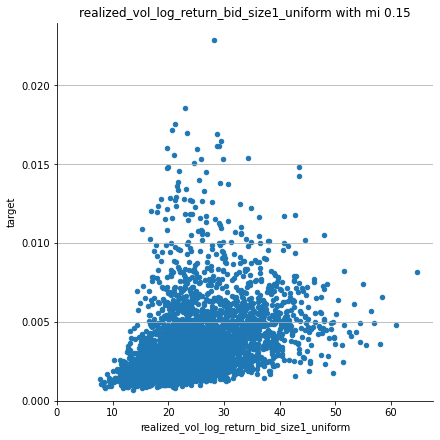

In [23]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
weights = 'uniform'
df_realized_vol = make_realized_volatility(df_book, col="bid_size1", weights=weights)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,size
time_id,
5,459
11,474


CPU times: user 413 ms, sys: 31.9 ms, total: 445 ms
Wall time: 443 ms


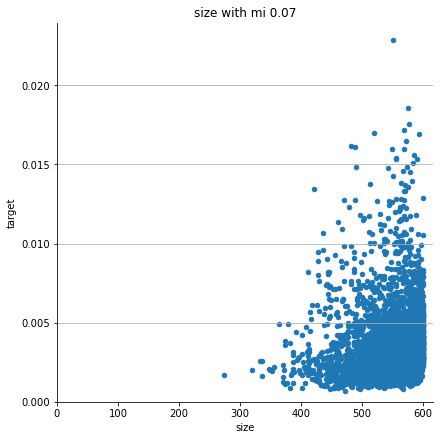

In [24]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
weights = 'uniform'
#df_realized_vol = make_realized_volatility(df_book, col="ask_size1", weights=weights)
df_realized_vol = df_book.groupby(['stock_id', 'time_id']).size().to_frame(name='size')
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,bid_size2
time_id,
5,25.0
11,36.0


CPU times: user 391 ms, sys: 19.3 ms, total: 411 ms
Wall time: 388 ms


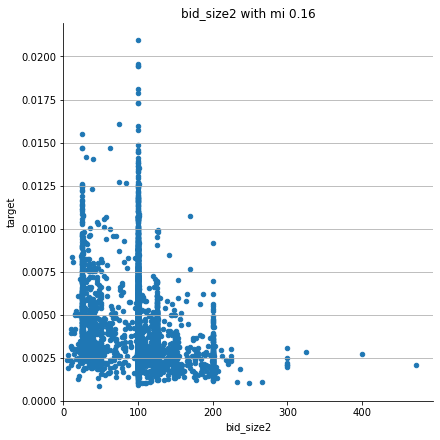

In [110]:
%%time 

df_book = df_book_orig.copy()
make_wap(df_book, 1) # adds 'wap' column
#df_realized_vol = df_book.groupby(['stock_id', 'time_id']).size().to_frame(name='size')
df_realized_vol=df_book.groupby(['stock_id', 'time_id'])[['bid_size2']].quantile(0.5)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

## Start of a bid-ask diff

,realized_vol_log_return_ask1_bid1_diff_uniform
time_id,
5,0.016485
11,0.009664


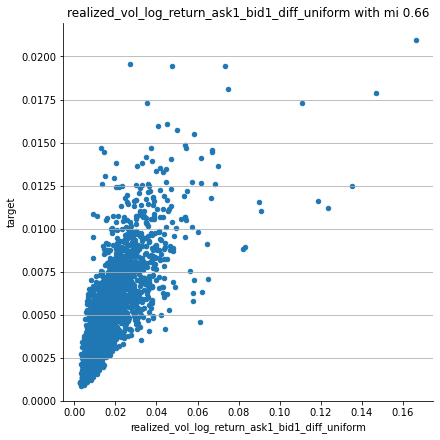

In [132]:
df_book = df_book_orig.copy()

# all 3 have value...
#df_book_data['ask1_bid1_diff'] = df_book_data['ask_price1'] - df_book_data['bid_price1']
# ask bid price 1 has very low MI
df_book['ask1_bid1_diff'] = (df_book['ask_price1'] - df_book['bid_price1'])
df_features = make_realized_volatility(df_book, 'ask1_bid1_diff', weights, apply_log_return=False)
df_features = df_features.reset_index('stock_id', drop=True)
col = df_features.columns[0] 
#col = df_realized.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

In [25]:
df_book = df_book_orig.copy()

# all 3 have value...
#df_book_data['ask1_bid1_diff'] = df_book_data['ask_price1'] - df_book_data['bid_price1']
# ask bid price 1 has very low MI
df_book['ask1_bid1_diff'] = (df_book['ask_price1'] / df_book['bid_price1']) - 1
# ask bid price 2 has higher MI
#df_book_data['ask1_bid1_diff'] = (df_book_data['ask_price2'] / df_book_data['bid_price2']) - 1
# these also have value
#df_book_data['ask1_bid1_diff'] = (df_book_data['ask_price1'] / df_book_data['bid_price2']) - 1
#df_book_data['ask1_bid1_diff'] = (df_book_data['ask_price2'] / df_book_data['bid_price1']) - 1

col = 'ask1_bid1_diff'
df_features = make_realized_volatility(df_book, col, weights)
df_features = df_features.reset_index('stock_id', drop=True)
col = df_features.columns[0] 

df_features.head(2)

,realized_vol_log_return_ask1_bid1_diff_uniform
time_id,
5,5.460844
11,4.140122


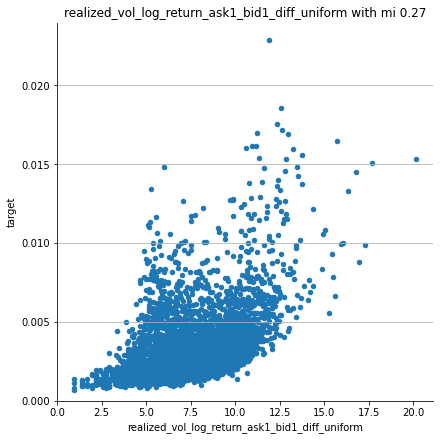

In [26]:
plot_mi(df_features, df_train_stock_id)

# Signal in trade data?

In [27]:
df_trade = df_trade_orig.copy()
#time_ids = set([5, 32767])
#df_trade_data = df_trade_data.query('time_id in @time_ids')
df_trade

seconds_in_bucket     price  size  order_count
stock_id time_id                                                
10       5                        1  1.000127     1            1
         5                        2  1.000106   400            8
         5                        3  1.000084   200            2
         5                        6  1.000495  1100            7
         5                        8  1.000380   315            3
...                             ...       ...   ...          ...
         32767                  581  0.999362   120            4
         32767                  588  0.999202   280            2
         32767                  592  0.999043     1            1
         32767                  594  0.998883   100            2
         32767                  595  0.998883   200            2

[527442 rows x 4 columns]

In [112]:
df_features = df_trade.groupby('time_id').agg(size_count=pd.NamedAgg('size', 'count'),
                                              size_var=pd.NamedAgg('size', 'var'),
                                              order_count_sum=pd.NamedAgg('order_count', 'sum'),
                                              order_count_var=pd.NamedAgg('order_count', 'var'))
df_features.reset_index()

,time_id,size_count,size_var,order_count_sum,order_count_var
0,5,94,55653.111874,312,10.327156
1,11,50,13173.897551,138,6.431020
2,16,82,13902.083258,226,5.075580
3,31,33,7953.251894,78,3.738636
4,62,25,3387.260000,47,1.276667
...,...,...,...,...,...
3825,32751,49,9181.591837,136,4.511054
3826,32753,183,275334.914070,1441,91.198403
3827,32758,26,4552.586154,68,5.366154
3828,32763,109,28638.400782,320,6.412504


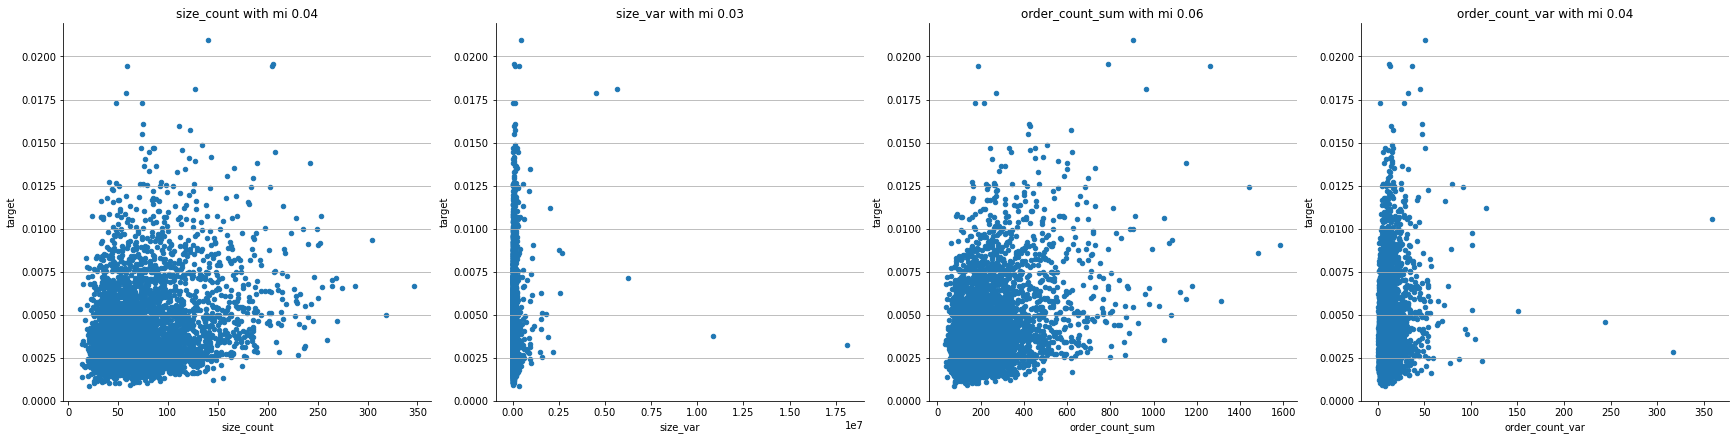

In [113]:
plot_mi(df_features, df_train_stock_id)

In [114]:
df_features = df_trade.groupby('time_id')['price'].agg(['var', 'size', 'mean', 'median'])
df_features.reset_index()

,time_id,var,size,mean,median
0,5,1.068564e-06,94,1.003740,1.003596
1,11,1.771144e-07,50,1.001913,1.001906
2,16,7.571151e-07,82,1.001130,1.001312
3,31,4.392595e-07,33,0.997599,0.997678
4,62,1.348300e-07,25,1.000791,1.000746
...,...,...,...,...,...
3825,32751,8.191095e-08,49,1.000126,1.000134
3826,32753,3.568482e-05,183,1.008091,1.010750
3827,32758,3.602819e-07,26,1.000818,1.000938
3828,32763,2.617230e-06,109,1.003131,1.003752


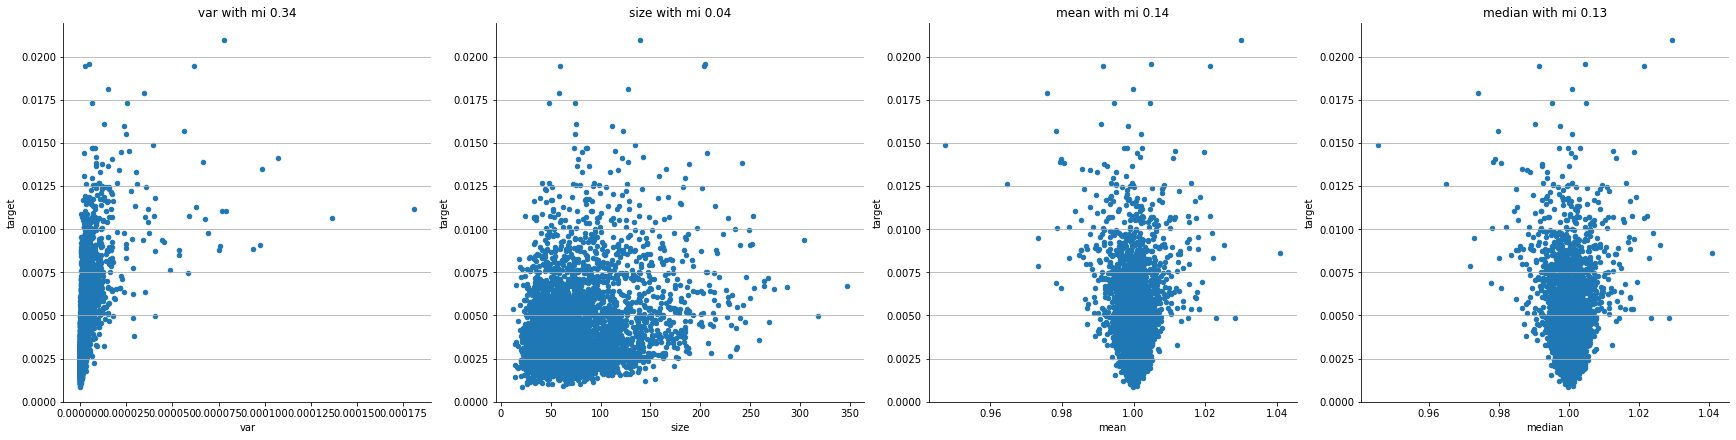

In [115]:
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_price_uniform
time_id,
5,0.003087
11,0.001700


CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 1.81 s


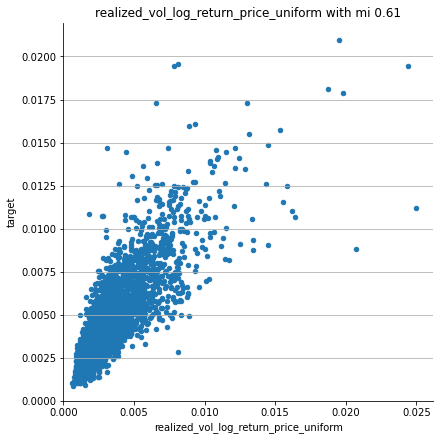

In [81]:
%%time 

df_trade = df_trade_orig.copy()
df_realized_vol = make_realized_volatility(df_trade, col="price", weights='uniform')
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)

,realized_vol_log_return_order_count_uniform
time_id,
5,11.100107
11,6.880458


CPU times: user 2.22 s, sys: 7.63 ms, total: 2.22 s
Wall time: 2.22 s


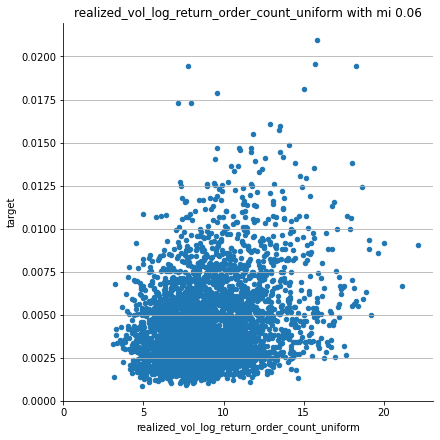

In [83]:
%%time 

df_trade = df_trade_orig.copy()
df_realized_vol = make_realized_volatility(df_trade, col="order_count", weights='uniform')
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = df_realized_vol.columns[0] 
display(df_features.head(2))
plot_mi(df_features, df_train_stock_id)